# Libraries

In [53]:
import os
import shutil
import gc
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
from collections import Counter
import keras.layers as kl
from PIL import Image, ImageFile
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.optimizers import Adam

In [54]:
targetnames = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_classes = len(targetnames)
batch_size = 16
image_size = 224
print(num_classes)

7


In [55]:
import os, shutil, random
import pandas as pd
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from PIL import Image

# ==== INPUTS (Kaggle dataset) ====
BASE = "/kaggle/input/skin-cancer-mnist-ham10000"
IMG_DIRS = [
    os.path.join(BASE, "HAM10000_images_part_1"),
    os.path.join(BASE, "HAM10000_images_part_2"),
]
META_CSV = os.path.join(BASE, "HAM10000_metadata.csv")

In [56]:
OUT_BASE = "/kaggle/working/HAM10K/Splits"
TRAIN_DIR = os.path.join(OUT_BASE, "train_dir")
VAL_DIR   = os.path.join(OUT_BASE, "val_dir")
TEST_DIR  = os.path.join(OUT_BASE, "test_dir")

CLASSES_UPPER = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
DX_TO_CLASS = {  # metadata 'dx' → folder name
    'akiec': 'AKIEC', 'bcc': 'BCC', 'bkl': 'BKL', 'df': 'DF',
    'mel': 'MEL', 'nv': 'NV', 'vasc': 'VASC'
}

In [57]:
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)
    for c in CLASSES_UPPER:
        os.makedirs(os.path.join(d, c), exist_ok=True)

In [58]:
# Merge metadata with actual image paths

# Load metadata
meta = pd.read_csv(META_CSV)

# Build a lookup from image_id -> absolute path by scanning both parts
id_to_path = {}
for root in IMG_DIRS:
    for p in glob(os.path.join(root, "*.jpg")):
        # filename looks like ISIC_XXXXX.jpg
        image_id = os.path.splitext(os.path.basename(p))[0]
        id_to_path[image_id] = p

# Keep only rows with an existing image file
meta = meta[meta['image_id'].isin(id_to_path.keys())].copy()

# Map 'dx' to our uppercase class names
meta['label'] = meta['dx'].map(DX_TO_CLASS)

# Add absolute image paths
meta['img_path'] = meta['image_id'].map(id_to_path)

# Sanity check
print(meta[['image_id','dx','label','img_path']].head())
print("Counts:", meta['label'].value_counts().to_dict())


       image_id   dx label                                           img_path
0  ISIC_0027419  bkl   BKL  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1  ISIC_0025030  bkl   BKL  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2  ISIC_0026769  bkl   BKL  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3  ISIC_0025661  bkl   BKL  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4  ISIC_0031633  bkl   BKL  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...
Counts: {'NV': 6705, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327, 'VASC': 142, 'DF': 115}


In [59]:
# Split 20% test, then 20% val from the remaining 80% → about 60/20/20
train_val, test = train_test_split(
    meta, test_size=0.2, random_state=42, stratify=meta['label']
)
train, val = train_test_split(
    train_val, test_size=0.25, random_state=42, stratify=train_val['label'] 
)

print("Train:", Counter(train['label']))
print("Val:  ", Counter(val['label']))
print("Test: ", Counter(test['label']))


Train: Counter({'NV': 4023, 'MEL': 668, 'BKL': 659, 'BCC': 308, 'AKIEC': 197, 'VASC': 85, 'DF': 69})
Val:   Counter({'NV': 1341, 'MEL': 222, 'BKL': 220, 'BCC': 103, 'AKIEC': 65, 'VASC': 29, 'DF': 23})
Test:  Counter({'NV': 1341, 'MEL': 223, 'BKL': 220, 'BCC': 103, 'AKIEC': 65, 'VASC': 28, 'DF': 23})


# Dataset generation (Train, Test, Validation)

In [60]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [61]:
def copy_split(rows, dest_root):
    for _, r in rows.iterrows():
        src = r['img_path']
        cls = r['label']
        dst = os.path.join(dest_root, cls, os.path.basename(src))
        if not os.path.exists(dst):
            try:
                with Image.open(src) as img:
                    img.verify()  # Verify image integrity
                shutil.copy2(src, dst)
            except Exception as e:
                print(f"Error copying {src}: {e}")

copy_split(train, TRAIN_DIR)
copy_split(val, VAL_DIR)
copy_split(test, TEST_DIR)

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    print(f"\nChecking {d}:")
    for c in CLASSES_UPPER:
        class_dir = os.path.join(d, c)
        num_files = len(glob(os.path.join(class_dir, "*.jpg")))
        print(f"  {c}: {num_files} images")

print("Train samples copied:", sum(len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in CLASSES_UPPER))
print("Val samples copied:", sum(len(os.listdir(os.path.join(VAL_DIR, c))) for c in CLASSES_UPPER))
print("Test samples copied:", sum(len(os.listdir(os.path.join(TEST_DIR, c))) for c in CLASSES_UPPER))


Checking /kaggle/working/HAM10K/Splits/train_dir:
  AKIEC: 197 images
  BCC: 308 images
  BKL: 659 images
  DF: 69 images
  MEL: 668 images
  NV: 4023 images
  VASC: 85 images

Checking /kaggle/working/HAM10K/Splits/val_dir:
  AKIEC: 65 images
  BCC: 103 images
  BKL: 220 images
  DF: 23 images
  MEL: 222 images
  NV: 1341 images
  VASC: 29 images

Checking /kaggle/working/HAM10K/Splits/test_dir:
  AKIEC: 65 images
  BCC: 103 images
  BKL: 220 images
  DF: 23 images
  MEL: 223 images
  NV: 1341 images
  VASC: 28 images
Train samples copied: 6009
Val samples copied: 2003
Test samples copied: 2003


In [62]:
print("\nTrain Batches:")
train_batches = datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

print("\nValidation Batches:")
val_batches = datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

print("\nTest Batches:")
test_batches = datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)


Train Batches:
Found 6009 images belonging to 7 classes.

Validation Batches:
Found 2003 images belonging to 7 classes.

Test Batches:
Found 2003 images belonging to 7 classes.


In [63]:
# Verify data pipeline
print("Class indices:", train_batches.class_indices)
print(f"Train samples: {train_batches.samples}")
print(f"Validation samples: {val_batches.samples}")
print(f"Test samples: {test_batches.samples}")
print("Testing train_batches...")
for images, labels in train_batches:
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")
    break

Class indices: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
Train samples: 6009
Validation samples: 2003
Test samples: 2003
Testing train_batches...
Batch shape: (16, 224, 224, 3), Labels shape: (16, 7)


### Define Model

In [64]:
tf.keras.backend.clear_session()
gc.collect()

base = DenseNet201(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
base.trainable = False  # Freeze for warm-up

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [43]:
inp = Input(shape=(image_size, image_size, 3))
x = base(inp, training=False)
x = Conv2D(512, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.35)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(num_classes, activation="softmax")(x)

In [44]:
model_dn201 = Model(inp, out)
model_dn201.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model_dn201.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     8,847,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,488,007 (108.67 MB)

 Trainable params: 10,164,487 (38.77 MB)

 Non-trainable params: 18,323,520 (69.90 MB)

In [20]:
# densenet = DN201(MainInput)

In [21]:
# # Reshape the tensor to have 4 dimensions
# from tensorflow.keras.layers import Reshape
# reshape = Reshape((8, 8, 30))(densenet)

In [22]:
# conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape)
# conv = BatchNormalization()(conv)
# conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
# conv = BatchNormalization()(conv)
# conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
# conv = BatchNormalization()(conv)
# conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
# conv = BatchNormalization()(conv)

In [23]:
# conv = (Flatten()(conv))
# conv = (Dense(1024,activation="relu")(conv))
# conv = Dropout(0.35)(conv)
# conv = (Dense(512,activation="relu")(conv))
# conv = Dropout(0.25)(conv)
# conv = (Dense(num_classes, activation="softmax")(conv))

# model_dn201 = Model(inputs=MainInput, outputs=conv)

In [33]:
# model_dn201 = Model(inp, out)
# model_dn201.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#                     loss="categorical_crossentropy",
#                     metrics=["accuracy"])

In [25]:
# opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
# model_dn201.compile(optimizer=opt1,
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

In [45]:
classes = np.array(range(num_classes))
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_batches.classes)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 4.357505438723713, 1: 2.787105751391466, 2: 1.3026230218946455, 3: 12.440993788819876, 4: 1.2850727117194183, 5: 0.21338020666879728, 6: 10.099159663865546}


In [35]:
# classes = np.arange(num_classes)
# y_indices = train_batches.classes
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_indices)
# class_weights = {i: float(w) for i, w in enumerate(weights)}
# print("class_weights:", class_weights)

class_weights: {0: 4.357505438723713, 1: 2.787105751391466, 2: 1.3026230218946455, 3: 12.440993788819876, 4: 1.2850727117194183, 5: 0.21338020666879728, 6: 10.099159663865546}


In [46]:
checkpoint = ModelCheckpoint("densenet201_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

> > 

In [47]:
train_batches.reset()
val_batches.reset()
steps_per_epoch = max(1, train_batches.samples // batch_size)
validation_steps = max(1, val_batches.samples // batch_size)
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

Steps per epoch: 375, Validation steps: 125


In [48]:
history = model_dn201.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_batches,
    validation_steps=validation_steps,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4326 - loss: 1.7467
Epoch 1: val_accuracy improved from -inf to 0.59200, saving model to densenet201_best.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 249ms/step - accuracy: 0.4327 - loss: 1.7461 - val_accuracy: 0.5920 - val_loss: 0.9982 - learning_rate: 0.0010
Epoch 2/20
  1/375 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.6250 - loss: 1.1017

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.59200 to 0.60600, saving model to densenet201_best.h5
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.6250 - loss: 1.1017 - val_accuracy: 0.6060 - val_loss: 0.9749 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5644 - loss: 1.1284
Epoch 3: val_accuracy did not improve from 0.60600
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.5644 - loss: 1.1283 - val_accuracy: 0.5435 - val_loss: 1.2643 - learning_rate: 0.0010
Epoch 4/20
  1/375 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.4375 - loss: 0.3533
Epoch 4: val_accuracy did not improve from 0.60600
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.4375 - loss: 0.3533 - val_accuracy: 0.5410 - val_loss: 1.2708 - learning_rate: 0.0010
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6041 - loss: 0.8574
Epoch 5: val_accuracy improved from 0.60600 to 0.63750, saving model to densenet201_best.h5
375/375 ━━━━━━━━━━━

In [52]:
model_dn201.save('DN_hist1.h5')

In [53]:
print(os.listdir('/kaggle/working/'))

['densenet201_best.h5', '.virtual_documents', 'DN_Model.h5', 'HAM10K', 'DN_hist1.h5']


In [54]:
from IPython.display import FileLink
FileLink("DN_hist1.h5")

/kaggle/working/DN_hist1.h5

In [55]:
base.trainable = True
cut = int(len(base.layers) * 0.66)
for i, layer in enumerate(base.layers):
    layer.trainable = (i > cut)

model_dn201.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [61]:
train_batches.reset()
val_batches.reset()
history_fine = model_dn201.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_batches,
    validation_steps=validation_steps,
    epochs=40,  # Set to 40 as requested
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6382 - loss: 1.3342
Epoch 1: val_accuracy did not improve from 0.74800
375/375 ━━━━━━━━━━━━━━━━━━━━ 261s 325ms/step - accuracy: 0.6382 - loss: 1.3339 - val_accuracy: 0.6450 - val_loss: 1.0130 - learning_rate: 1.0000e-04
Epoch 2/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 49s 133ms/step - accuracy: 0.6250 - loss: 1.0937
Epoch 2: val_accuracy did not improve from 0.74800
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.6250 - loss: 1.0937 - val_accuracy: 0.6445 - val_loss: 1.0064 - learning_rate: 1.0000e-04
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7374 - loss: 0.5350
Epoch 3: val_accuracy did not improve from 0.74800
375/375 ━━━━━━━━━━━━━━━━━━━━ 65s 174ms/step - accuracy: 0.7374 - loss: 0.5347 - val_accuracy: 0.7110 - val_loss: 0.8096 - learning_rate: 1.0000e-04
Epoch 4/40
  1/375 ━━━━━━━━━━━━━━━━━━━━ 49s 132ms/step - accuracy: 0.8750 - loss: 0.2310
Epoch 4: val_accuracy did not improve from 0.7480

In [35]:
# model_dn201.save('DN_fine_tuned.h5')

In [65]:
# Path to saved model (update based on your environment)
model_path = '/kaggle/input/dn_finetuned/keras/default/1/DN_fine_tuned.h5'  # Adjust if in a specific directory (e.g., '/path/to/DN_fine_tuned.h5')

# Load the model
model_dn201 = tf.keras.models.load_model(model_path)

# Verify model architecture (optional)
model_dn201.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 512)      │     8,847,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,488,009 (108.67 MB)

 Trainable params: 19,058,887 (72.70 MB)

 Non-trainable params: 9,429,120 (35.97 MB)

 Optimizer params: 2 (12.00 B)

In [38]:
print(os.listdir('/kaggle/working/'))

['.virtual_documents', 'HAM10K']


In [39]:
from IPython.display import FileLink
FileLink("DN_fine_tuned.h5")

/kaggle/working/DN_fine_tuned.h5

In [56]:
base.trainable = True
model_dn201.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
TEST_DIR = "/kaggle/working/HAM10K/Splits/test_dir"

In [66]:
test_batches.reset()
test_loss, test_acc = model_dn201.evaluate(test_batches, steps=max(1, test_batches.samples // batch_size))
print(f"Test Accuracy: {test_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.7857 - loss: 0.8186
Test Accuracy: 83.75%


In [67]:
print(f"Test samples: {test_batches.samples}")
print(f"Number of batches: {test_batches.samples // batch_size + (1 if test_batches.samples % batch_size else 0)}")

Test samples: 2003
Number of batches: 126


In [68]:
# Generate predictions (use full iterator)
test_batches.reset()
predictions = model_dn201.predict(test_batches)  # Omit steps to process all samples
y_pred_original = np.argmax(predictions, axis=1)
y_true = test_batches.classes

126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 259ms/step


In [45]:
# # Trim y_pred to match y_true if necessary (due to batch padding)
# if len(y_pred_original) > len(y_true):
#     y_pred_original = y_pred_original[:len(y_true)]
# elif len(y_pred_original) < len(y_true):
#     # This case is unlikely but handle it by padding with the last prediction
#     y_pred_original = np.pad(y_pred_original, (0, len(y_true) - len(y_pred_original)), mode='edge')

In [69]:
min_length = min(len(y_true), len(y_pred_original))
y_true = y_true[:min_length]
y_pred_original = y_pred_original[:min_length]

In [70]:
# Original Metrics
print("Original Accuracy:", accuracy_score(y_true, y_pred_original))
print("Original Classification Report:\n", classification_report(y_true, y_pred_original, target_names=targetnames))
conf_mat_original = confusion_matrix(y_true, y_pred_original)
print("Original Confusion Matrix:\n", conf_mat_original)

Original Accuracy: 0.8377433849226161
Original Classification Report:
               precision    recall  f1-score   support

       AKIEC       0.61      0.68      0.64        65
         BCC       0.66      0.85      0.75       103
         BKL       0.71      0.75      0.73       220
          DF       0.60      0.65      0.63        23
         MEL       0.59      0.69      0.64       223
          NV       0.95      0.89      0.92      1341
        VASC       0.75      0.86      0.80        28

    accuracy                           0.84      2003
   macro avg       0.70      0.77      0.73      2003
weighted avg       0.85      0.84      0.84      2003

Original Confusion Matrix:
 [[  44    4    5    1    7    4    0]
 [   5   88    5    0    1    3    1]
 [  12   10  165    2   15   16    0]
 [   1    3    0   15    1    3    0]
 [   3    9   20    1  154   34    2]
 [   7   17   37    5   82 1188    5]
 [   0    2    0    1    1    0   24]]


### Plotting accuracy and loss

In [71]:
def merge_histories(h1, h2):
    merged = {}
    keys = set(h1.history.keys()) | set(h2.history.keys())
    for k in keys:
        merged[k] = h1.history.get(k, []) + h2.history.get(k, [])
    class H: pass
    H.history = merged
    return H

history_all = merge_histories(history, history_fine)
history = history_all  # reuse the plotting code above as-is


NameError: name 'history' is not defined

Number of epochs trained: 15


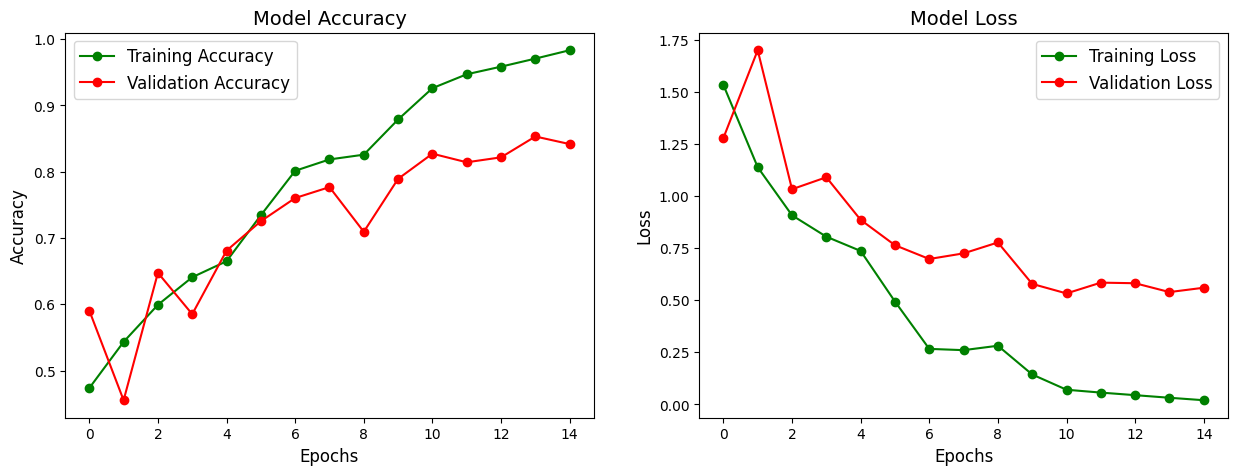

In [54]:
# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

## History plotting
epochs = [i for i in range(num_epochs_trained)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}
ax[0].set_xlabel("Epochs",  fontdict=label_font)
ax[0].set_ylabel("Accuracy",  fontdict=label_font)

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)
plt.show()

**real augmentation (you’re not augmenting right now)**

In [72]:
mcc_original = matthews_corrcoef(y_true, y_pred_original)
kappa_original = cohen_kappa_score(y_true, y_pred_original)
print("Original MCC: {:.2f}%".format(mcc_original * 100))
print("Original Kappa Score: {:.2f}%".format(kappa_original * 100))

Original MCC: 70.79%
Original Kappa Score: 70.54%


In [73]:
# Per-Class MCC and Kappa (Original)
mcc_per_class_original = {}
kappa_per_class_original = {}
for i in range(num_classes):
    tp = conf_mat_original[i][i]
    fp = sum(conf_mat_original[:, i]) - tp
    fn = sum(conf_mat_original[i, :]) - tp
    tn = sum(sum(conf_mat_original)) - tp - fp - fn
    binary_true = [1 if x == i else 0 for x in y_true]
    binary_pred = [1 if x == i else 0 for x in y_pred_original]
    mcc_per_class_original[i] = matthews_corrcoef(binary_true, binary_pred)
    kappa_per_class_original[i] = cohen_kappa_score(binary_true, binary_pred)

print("Original MCC per class:")
for i, mcc in mcc_per_class_original.items():
    print(f"Class {targetnames[i]}: {mcc * 100:.2f}%")
print("Original Kappa Score per class:")
for i, kappa in kappa_per_class_original.items():
    print(f"Class {targetnames[i]}: {kappa * 100:.2f}%")

Original MCC per class:
Class AKIEC: 63.06%
Class BCC: 73.69%
Class BKL: 69.61%
Class DF: 62.10%
Class MEL: 58.91%
Class NV: 77.19%
Class VASC: 79.88%
Original Kappa Score per class:
Class AKIEC: 62.97%
Class BCC: 73.01%
Class BKL: 69.58%
Class DF: 62.05%
Class MEL: 58.67%
Class NV: 76.80%
Class VASC: 79.70%


In [74]:
class_weights = [4.36, 2.79, 1.30, 12.44, 1.29, 0.21, 10.99]  # From your training output
thresholds = [0.3 if w > 2.0 else 0.5 for w in class_weights]  # Lower for high-weight classes

y_pred_threshold = np.array([np.argmax([p[i] if p[i] > thresholds[i] else 0 for i in range(len(p))]) for p in predictions[:min_length]])
print("\nThreshold-Adjusted Accuracy:", accuracy_score(y_true, y_pred_threshold))
print("Threshold-Adjusted Classification Report:\n", classification_report(y_true, y_pred_threshold, target_names=targetnames))
conf_mat_threshold = confusion_matrix(y_true, y_pred_threshold)
print("Threshold-Adjusted Confusion Matrix:\n", conf_mat_threshold)


Threshold-Adjusted Accuracy: 0.8332501248127808
Threshold-Adjusted Classification Report:
               precision    recall  f1-score   support

       AKIEC       0.49      0.74      0.59        65
         BCC       0.65      0.85      0.74       103
         BKL       0.73      0.74      0.73       220
          DF       0.58      0.65      0.61        23
         MEL       0.60      0.68      0.64       223
          NV       0.95      0.88      0.92      1341
        VASC       0.73      0.86      0.79        28

    accuracy                           0.83      2003
   macro avg       0.68      0.77      0.72      2003
weighted avg       0.85      0.83      0.84      2003

Threshold-Adjusted Confusion Matrix:
 [[  48    4    4    1    5    3    0]
 [   7   88    4    0    1    2    1]
 [  16   10  162    3   14   15    0]
 [   1    3    0   15    1    3    0]
 [   9   10   15    1  152   34    2]
 [  16   18   36    5   80 1180    6]
 [   0    2    0    1    1    0   24]]


In [75]:
# MCC and Kappa (Threshold-Adjusted)
mcc_threshold = matthews_corrcoef(y_true, y_pred_threshold)
kappa_threshold = cohen_kappa_score(y_true, y_pred_threshold)
print("Threshold-Adjusted MCC: {:.2f}%".format(mcc_threshold * 100))
print("Threshold-Adjusted Kappa Score: {:.2f}%".format(kappa_threshold * 100))

Threshold-Adjusted MCC: 70.27%
Threshold-Adjusted Kappa Score: 69.95%


In [76]:
# Per-Class MCC and Kappa (Threshold-Adjusted)
mcc_per_class_threshold = {}
kappa_per_class_threshold = {}
for i in range(num_classes):
    tp = conf_mat_threshold[i][i]
    fp = sum(conf_mat_threshold[:, i]) - tp
    fn = sum(conf_mat_threshold[i, :]) - tp
    tn = sum(sum(conf_mat_threshold)) - tp - fp - fn
    binary_true = [1 if x == i else 0 for x in y_true]
    binary_pred = [1 if x == i else 0 for x in y_pred_threshold]
    mcc_per_class_threshold[i] = matthews_corrcoef(binary_true, binary_pred)
    kappa_per_class_threshold[i] = cohen_kappa_score(binary_true, binary_pred)

print("Threshold-Adjusted MCC per class:")
for i, mcc in mcc_per_class_threshold.items():
    print(f"Class {targetnames[i]}: {mcc * 100:.2f}%")
print("Threshold-Adjusted Kappa Score per class:")
for i, kappa in kappa_per_class_threshold.items():
    print(f"Class {targetnames[i]}: {kappa * 100:.2f}%")

Threshold-Adjusted MCC per class:
Class AKIEC: 58.87%
Class BCC: 73.08%
Class BKL: 70.19%
Class DF: 60.86%
Class MEL: 59.01%
Class NV: 76.84%
Class VASC: 78.63%
Threshold-Adjusted Kappa Score per class:
Class AKIEC: 57.61%
Class BCC: 72.34%
Class BKL: 70.19%
Class DF: 60.75%
Class MEL: 58.85%
Class NV: 76.35%
Class VASC: 78.36%


In [82]:
# Method 2: Weight Predictions with Inverse Class Weights
inverse_weights = [1/w for w in class_weights]
weighted_predictions = predictions[:min_length] * np.array(inverse_weights)
y_pred_weighted = np.argmax(weighted_predictions, axis=1)
print("\nWeight-Adjusted Accuracy:", accuracy_score(y_true, y_pred_weighted))
# print("Weight-Adjusted Classification Report:\n", classification_report(y_true, y_pred_weighted, targetnames))
conf_mat_weighted = confusion_matrix(y_true, y_pred_weighted)
print("Weight-Adjusted Confusion Matrix:\n", conf_mat_weighted)


Weight-Adjusted Accuracy: 0.8607089365951074
Weight-Adjusted Confusion Matrix:
 [[  38    3    3    0    5   16    0]
 [   4   76    4    0    2   17    0]
 [   7    4  150    2   15   42    0]
 [   1    2    1   12    1    6    0]
 [   1    6   11    0  140   65    0]
 [   1    8   13    0   31 1286    2]
 [   0    1    0    0    1    4   22]]


In [83]:
# MCC and Kappa (Weight-Adjusted)
mcc_weighted = matthews_corrcoef(y_true, y_pred_weighted)
kappa_weighted = cohen_kappa_score(y_true, y_pred_weighted)
print("Weight-Adjusted MCC: {:.2f}%".format(mcc_weighted * 100))
print("Weight-Adjusted Kappa Score: {:.2f}%".format(kappa_weighted * 100))

Weight-Adjusted MCC: 72.23%
Weight-Adjusted Kappa Score: 71.89%


In [84]:
# Per-Class MCC and Kappa (Weight-Adjusted)
mcc_per_class_weighted = {}
kappa_per_class_weighted = {}
for i in range(num_classes):
    tp = conf_mat_weighted[i][i]
    fp = sum(conf_mat_weighted[:, i]) - tp
    fn = sum(conf_mat_weighted[i, :]) - tp
    tn = sum(sum(conf_mat_weighted)) - tp - fp - fn
    binary_true = [1 if x == i else 0 for x in y_true]
    binary_pred = [1 if x == i else 0 for x in y_pred_weighted]
    mcc_per_class_weighted[i] = matthews_corrcoef(binary_true, binary_pred)
    kappa_per_class_weighted[i] = cohen_kappa_score(binary_true, binary_pred)

print("Weight-Adjusted MCC per class:")
for i, mcc in mcc_per_class_weighted.items():
    print(f"Class {targetnames[i]}: {mcc * 100:.2f}%")
print("Weight-Adjusted Kappa Score per class:")
for i, kappa in kappa_per_class_weighted.items():
    print(f"Class {targetnames[i]}: {kappa * 100:.2f}%")

Weight-Adjusted MCC per class:
Class AKIEC: 64.34%
Class BCC: 73.55%
Class BKL: 72.22%
Class DF: 66.59%
Class MEL: 63.34%
Class NV: 76.48%
Class VASC: 84.67%
Weight-Adjusted Kappa Score per class:
Class AKIEC: 63.92%
Class BCC: 73.54%
Class BKL: 71.82%
Class DF: 64.56%
Class MEL: 63.16%
Class NV: 76.00%
Class VASC: 84.41%


In [62]:
# from tensorflow.keras import models
# model_dn201.load_weights("DN201.weights.h5")

In [ ]:
# h5_path = "/kaggle/working/DN_Model.h5"   # adjust if different
# assert os.path.exists(h5_path), f"Not found: {h5_path}"
# model = tf.keras.models.load_model(h5_path, compile=False)

## Results

### Individual Class Accuracy 

### Individual Class Weighted Precision

### Individual Class Weighted Recall

### Individual Class Weighted F1-score

### Individual Class Precision, Recall and F1-score

### Individual Class Weighted Sensitivity

### Individual Class Weighted Specificity

### Accuracy

In [85]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, cohen_kappa_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import os

# Function to merge training histories
def merge_histories(h1, h2):
    merged = {}
    keys = set(h1.history.keys()) | set(h2.history.keys())  # Union of all metric keys
    for k in keys:
        merged[k] = h1.history.get(k, []) + h2.history.get(k, [])  # Concatenate lists
    class H: pass
    H.history = merged
    return H

# Attempt to load saved history logs (adjust paths based on where you saved them)
history = None
history_fine = None

In [86]:
# Check for CSV logs (example paths; adjust based on your setup)
csv_log_warmup = '/kaggle/working/training_warmup.log'  # Path for DN_hist1.h5 training
csv_log_finetune = '/kaggle/working/training_finetune.log'  # Path for DN_fine_tuned.h5 training

if os.path.exists(csv_log_warmup) and os.path.exists(csv_log_finetune):
    # Load histories from CSV if saved with CSVLogger
    history_df_warmup = pd.read_csv(csv_log_warmup)
    history_df_finetune = pd.read_csv(csv_log_finetune)
    
    # Convert to history-like objects
    history = type('H', (), {'history': {k: history_df_warmup[k].tolist() for k in history_df_warmup.columns if k != 'epoch'}})()
    history_fine = type('H', (), {'history': {k: history_df_finetune[k].tolist() for k in history_df_finetune.columns if k != 'epoch'}})()
    
    # Merge histories
    history_all = merge_histories(history, history_fine)
    history = history_all
    print("Histories loaded and merged successfully. Total epochs:", len(history.history['loss']))

    # Plotting the merged history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: History logs not found at specified paths. Ensure you used CSVLogger during training (e.g., csv_logger = CSVLogger('training.log')) and saved the files. Plotting skipped.")

## ROC

In [87]:
# Binarize the output for ROC curve (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_score = predictions[:min_length]  # Probability scores for each class

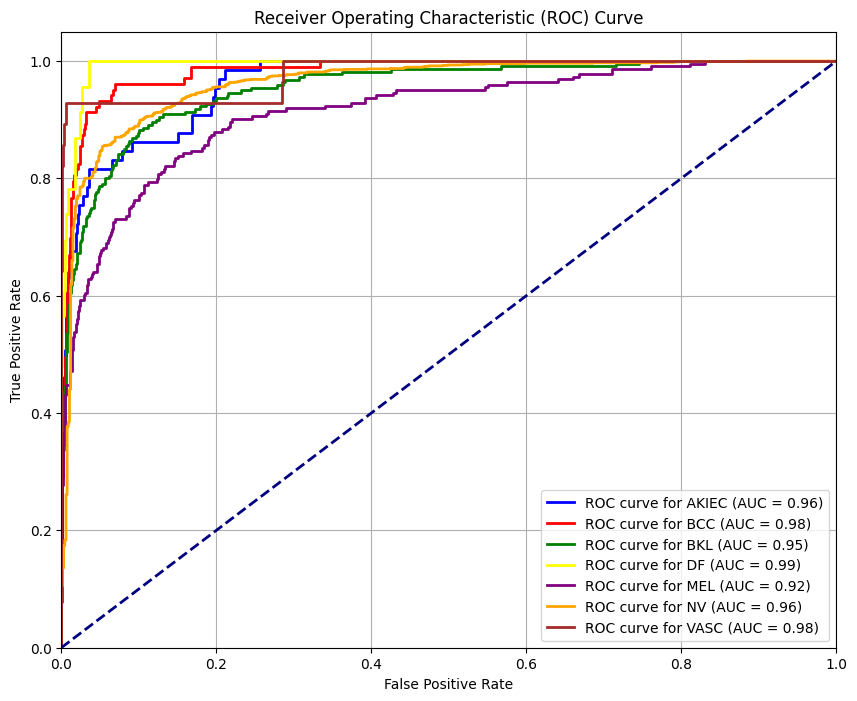

In [88]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'brown']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {targetnames[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Compute ROC curve and ROC area for each class

## Cross Dataset isic-2019

In [90]:
isic_dir = '/kaggle/input/isic-2019'
# /kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv
isic_csv = os.path.join(isic_dir, 'ISIC_2019_Training_GroundTruth.csv')

In [91]:
print(isic_csv)

/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv


In [93]:
ISIC_2019_Training_Input = os.path.join(isic_dir, 'ISIC_2019_Training_Input/ISIC_2019_Training_Input')

isic_df = pd.read_csv(isic_csv)

In [94]:
print("Columns:", isic_df.columns)
print("Shape:", isic_df.shape)
print(isic_df.head())

Columns: Index(['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')
Shape: (25331, 10)
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [95]:
isic_df.head(5)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
import os
for root, dirs, files in os.walk(isic_dir):
    print(root, len(files))


/kaggle/input/isic-2019 2
/kaggle/input/isic-2019/ISIC_2019_Training_Input 0
/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input 25333


In [97]:
# Set correct folder
# isic_images_folder = '/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

# Get all image paths
from glob import glob
import os

all_image_path = glob(os.path.join(ISIC_2019_Training_Input, '*.jpg'))

# Build mapping from image_id to full file path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Map to DataFrame
isic_df['path'] = isic_df['image'].map(imageid_path_dict.get)
isic_df = isic_df[isic_df['path'].notnull()]  # Only keep rows where image exists

isic_df.head(5)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...


In [98]:
print("First few image IDs from CSV:", isic_df['image'].head(10).tolist())
print("First few keys in imageid_path_dict:", list(imageid_path_dict.keys())[:10])


First few image IDs from CSV: ['ISIC_0000000', 'ISIC_0000001', 'ISIC_0000002', 'ISIC_0000003', 'ISIC_0000004', 'ISIC_0000006', 'ISIC_0000007', 'ISIC_0000008', 'ISIC_0000009', 'ISIC_0000010']
First few keys in imageid_path_dict: ['ISIC_0057312', 'ISIC_0014233_downsampled', 'ISIC_0059626', 'ISIC_0056156', 'ISIC_0030912', 'ISIC_0066845', 'ISIC_0060274', 'ISIC_0028933', 'ISIC_0030585', 'ISIC_0028394']


In [99]:
images = sorted(glob("/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/*.jpg"))
len(images)

25331

In [100]:
label_map = {
    'MEL': 'mel',   # Melanoma
    'NV': 'nv',     # Melanocytic nevus
    'BCC': 'bcc',   # Basal cell carcinoma
    'AK': 'akiec',  # Actinic keratosis (in HAM it's akiec)
    'BKL': 'bkl',   # Benign keratosis
    'DF': 'df',     # Dermatofibroma
    'VASC': 'vasc'  # Vascular
    # 'SCC' and 'UNK' are not in HAM10000, you can ignore or mark as -1
}

def get_label(row):
    for col, new_name in label_map.items():
        if row[col] == 1.0:
            return new_name
    return None  # or -1 for unknown class

isic_df['dx'] = isic_df.apply(get_label, axis=1)
isic_df = isic_df[isic_df['dx'].notnull()] 

In [103]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
isic_df['label'] = le.fit_transform(isic_df['dx'])
print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

Label mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [104]:
isic_df['label'] = le.transform(isic_df['dx'])

In [105]:
isic_df.head(5)

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,path,dx,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,nv,5
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,nv,5
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,mel,4
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,nv,5
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic-2019/ISIC_2019_Training_Inp...,mel,4


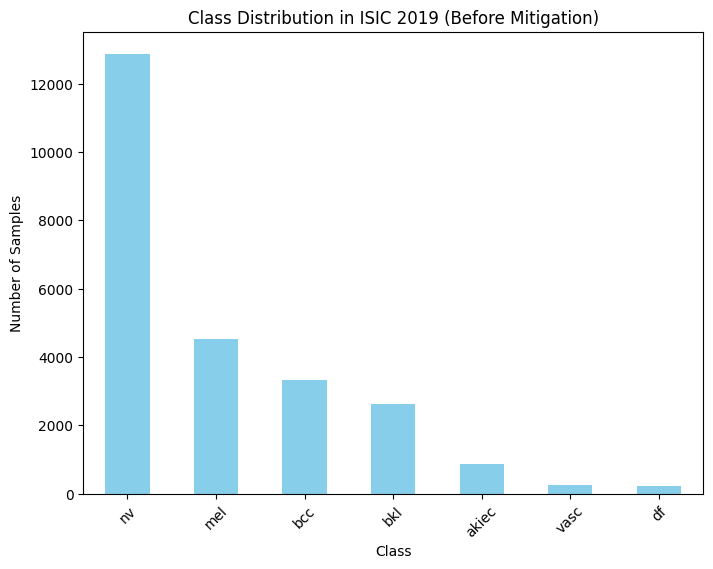

In [174]:
# Visualize class distribution before mitigation
plt.figure(figsize=(8, 6))
isic_df['dx'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in ISIC 2019 (Before Mitigation)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [164]:
# # Mitigate class imbalance by oversampling minority classes
# # Get the maximum class count
# max_class_count = isic_df['dx'].value_counts().max()

# # Oversample minority classes
# oversampled_df = pd.DataFrame()
# for cls in isic_df['dx'].unique():
#     cls_df = isic_df[isic_df['dx'] == cls]
#     oversample_ratio = max_class_count // len(cls_df)
#     if oversample_ratio > 1:
#         cls_df = pd.concat([cls_df] * oversample_ratio, ignore_index=True)
#         # Sample remaining to match max_class_count
#         remaining = max_class_count - len(cls_df)
#         if remaining > 0:
#             cls_df = pd.concat([cls_df, cls_df.sample(n=remaining, replace=True)], ignore_index=True)
#     else:
#         cls_df = cls_df.sample(n=max_class_count, replace=True)
#     oversampled_df = pd.concat([oversampled_df, cls_df], ignore_index=True)

# print(f"Oversampled dataset size: {len(oversampled_df)}")

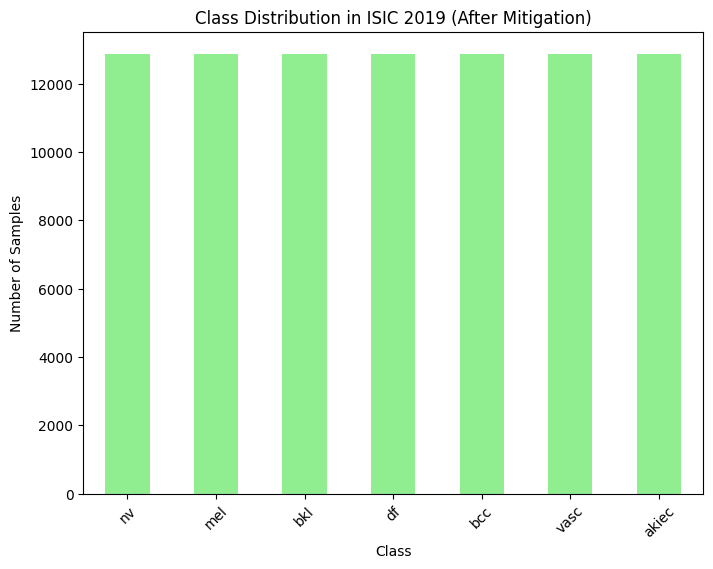

In [134]:
# # Visualize class distribution after mitigation
# plt.figure(figsize=(8, 6))
# oversampled_df['dx'].value_counts().plot(kind='bar', color='lightgreen')
# plt.title('Class Distribution in ISIC 2019 (After Mitigation)')
# plt.xlabel('Class')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=45)
# plt.show()

In [175]:
sample_fraction = 0.08
sampled_df = isic_df.sample(frac=sample_fraction, random_state=42)
print(f"Sampled {len(sampled_df)} images (8% of {len(isic_df)})")

Sampled 1976 images (8% of 24703)


In [184]:
TEST_DIR = "/kaggle/working/ISIC2019_Test"
os.makedirs(TEST_DIR, exist_ok=True)
for cls in le.classes_:
    os.makedirs(os.path.join(TEST_DIR, cls), exist_ok=True)

In [185]:
# Copy sampled images to test directory
def copy_split(rows, dest_root):
    for _, r in rows.iterrows():
        src = r['path']
        cls = r['dx']
        dst = os.path.join(dest_root, cls, os.path.basename(src))
        if not os.path.exists(dst):
            try:
                with Image.open(src) as img:
                    img.verify()  # Verify image integrity
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copy2(src, dst)
            except Exception as e:
                print(f"Error copying {src}: {e}")

copy_split(sampled_df, TEST_DIR)

In [186]:
# Data Generator for test set
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
test_batches = datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(224, 224),
    batch_size=16,
    shuffle=False,
    class_mode='categorical'
)

Found 1976 images belonging to 7 classes.


In [187]:
print(f"Test samples: {test_batches.samples}")

Test samples: 1976


In [188]:
# Evaluate on test set
test_batches.reset()
test_loss, test_acc = model_dn201.evaluate(test_batches, steps=max(1, test_batches.samples // 16))
print(f"Test Accuracy on ISIC 2019 (8% subset) with HAM10000 model: {test_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.5455 - loss: 3.0036
Test Accuracy on ISIC 2019 (8% subset) with HAM10000 model: 68.60%


In [192]:
test_batches.reset()
predictions = model_dn201.predict(test_batches)
y_pred_original = np.argmax(predictions, axis=1)
y_true = test_batches.classes

124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step


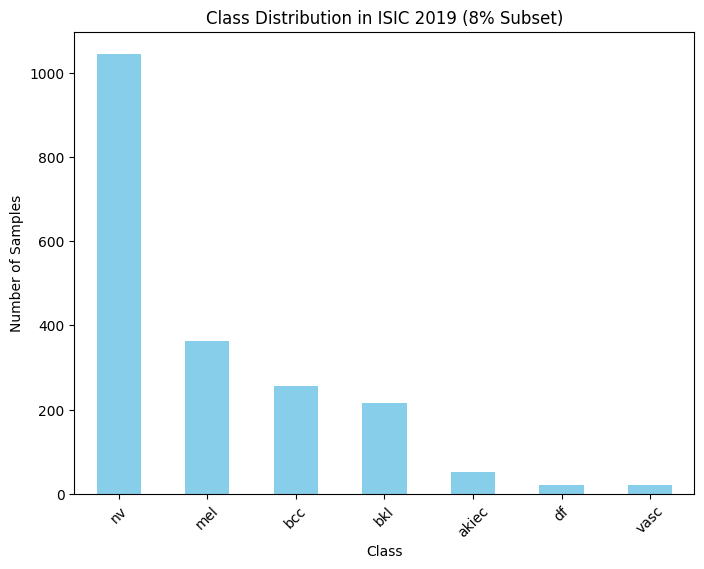

In [193]:
plt.figure(figsize=(8, 6))
sampled_df['dx'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution in ISIC 2019 (8% Subset)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [194]:
min_length = min(len(y_true), len(y_pred_original))
y_true = y_true[:min_length]
y_pred_original = y_pred_original[:min_length]

# Binarize the output for ROC curve
y_true_bin = label_binarize(y_true, classes=range(len(le.classes_)))
y_score = predictions[:min_length]

In [195]:
# Calculate class weights and apply threshold tuning
class_counts = test_df['dx'].value_counts()
total_samples = len(test_df)
class_weights = [total_samples / (len(le.classes_) * count) for count in class_counts]
thresholds = [0.3 if w > 2.0 else 0.5 for w in class_weights]
y_pred_threshold = np.array([np.argmax([p[i] if p[i] > thresholds[le.classes_.tolist().index(le.inverse_transform([i])[0])] else 0 for i in range(len(p))]) for p in predictions[:min_length]])

In [196]:
# Original Metrics and Plots
accuracy = accuracy_score(y_true, y_pred_original)
print("Original Accuracy:", accuracy)
report = classification_report(y_true, y_pred_original, target_names=le.classes_, output_dict=True)
conf_mat_original = confusion_matrix(y_true, y_pred_original)

Original Accuracy: 0.6857287449392713


In [120]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

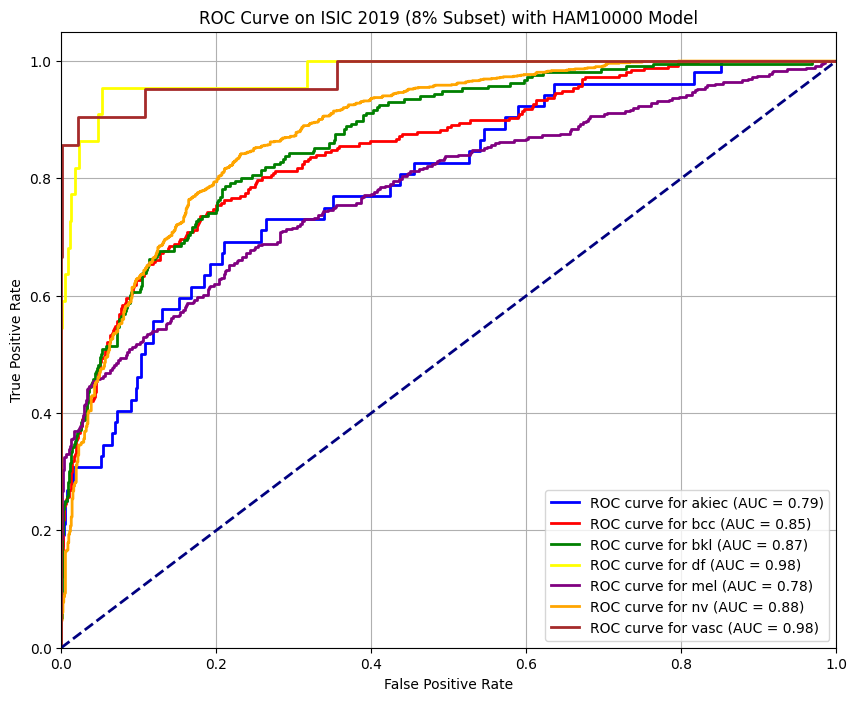

In [121]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'brown']
for i, color in zip(range(len(le.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on ISIC 2019 (8% Subset) with HAM10000 Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [122]:
# Original Metrics and Plots
accuracy = accuracy_score(y_true, y_pred_original)
print("Original Accuracy:", accuracy)
report = classification_report(y_true, y_pred_original, target_names=le.classes_, output_dict=True)
conf_mat_original = confusion_matrix(y_true, y_pred_original)

Original Accuracy: 0.6857287449392713


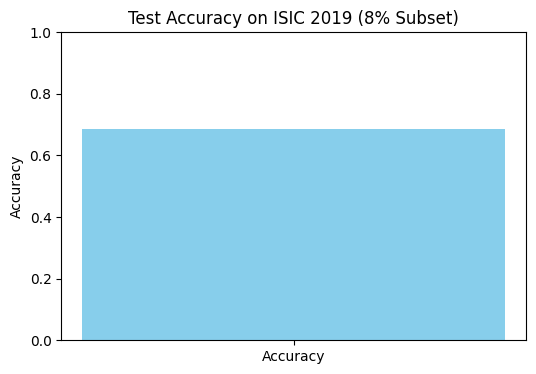

In [123]:
# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim(0, 1)
plt.title('Test Accuracy on ISIC 2019 (8% Subset)')
plt.ylabel('Accuracy')
plt.show()

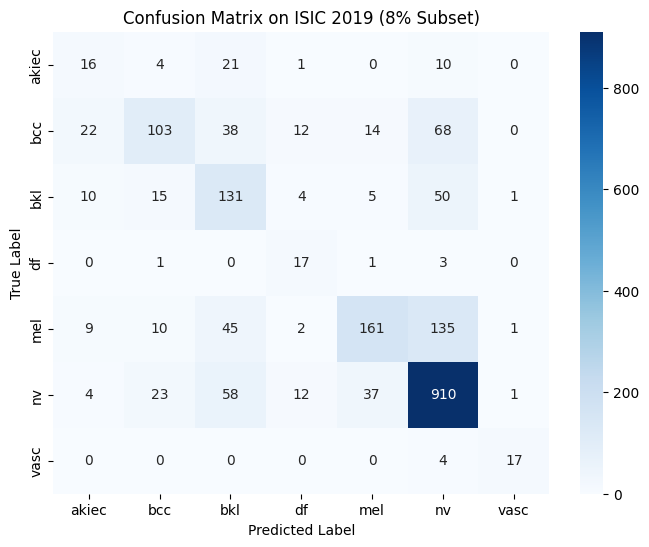

In [125]:

import seaborn as sns
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_original, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix on ISIC 2019 (8% Subset)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

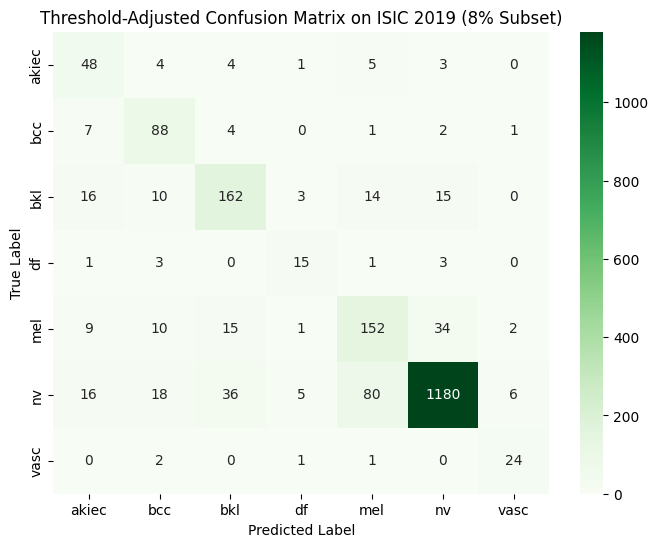

In [197]:
# Plot Confusion Matrix (Threshold-Adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_threshold, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Threshold-Adjusted Confusion Matrix on ISIC 2019 (8% Subset)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

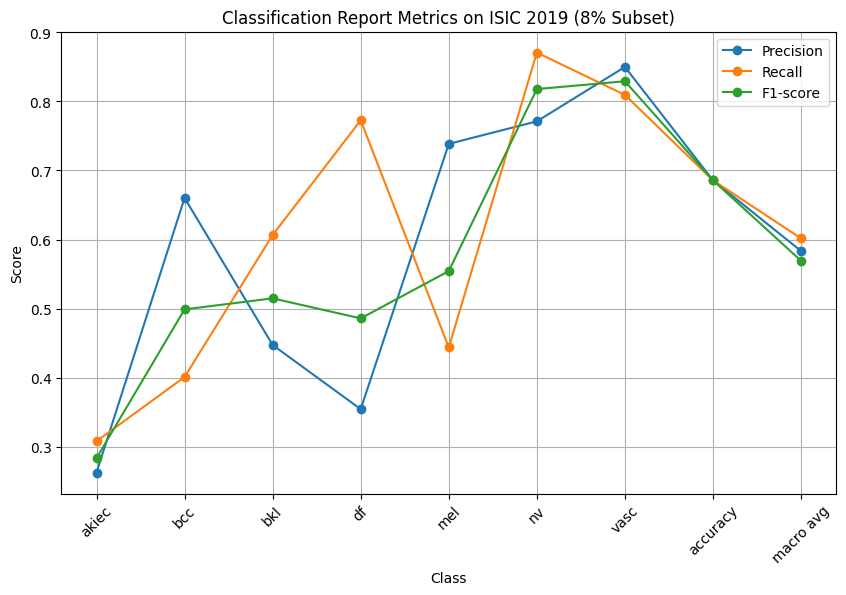

In [127]:
# Plot Classification Report Metrics
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame(report).transpose()
metrics_to_plot = ['precision', 'recall', 'f1-score']
for metric in metrics_to_plot:
    plt.plot(metrics_df.index[:-1], metrics_df[metric][:-1], marker='o', label=metric.capitalize())
plt.title('Classification Report Metrics on ISIC 2019 (8% Subset)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [216]:
# Grad-CAM Implementation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(f"Gradients shape: {grads.shape}, Min: {tf.reduce_min(grads)}, Max: {tf.reduce_max(grads)}")
    print(f"Pooled gradients shape: {pooled_grads.shape}, Min: {tf.reduce_min(pooled_grads)}, Max: {tf.reduce_max(pooled_grads)}")

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    print(f"Heatmap shape: {heatmap.shape}, Min: {tf.reduce_min(heatmap)}, Max: {tf.reduce_max(heatmap)}")
    return heatmap.numpy()

# Set the target layer (use a known DenseNet201 layer)
last_conv_layer_name = [layer.name for layer in model_dn201.layers if isinstance(layer, Conv2D)][-1]
# last_conv_layer_name = 'conv5_block32_concat'  # Last conv layer in DenseNet201 base

In [217]:
test_batches.reset()
images, _ = next(test_batches)
heatmap = make_gradcam_heatmap(images, model_dn201, last_conv_layer_name)

Gradients shape: (16, 7, 7, 256), Min: -1.615661494724918e-05, Max: 1.7942145859706216e-05
Pooled gradients shape: (256,), Min: -1.943755478350795e-06, Max: 2.0447866972972406e-06
Heatmap shape: (7, 7), Min: 0.03194797411561012, Max: 1.0


In [201]:
# # Generate Grad-CAM for a few HAM10000 test images
# test
# test_batches_ham.reset()
# images, _ = next(test_batches_ham)
# heatmap_ham = make_gradcam_heatmap(images, model_dn201, last_conv_layer_name)

In [203]:
# # Generate Grad-CAM for a few ISIC 2019 test images
# test_batches.reset()
# images_isic, _ = next(test_batches)
# heatmap_isic = make_gradcam_heatmap(images_isic, model_dn201, last_conv_layer_name)

In [209]:
import pandas as pd
import numpy as np
import cv2

In [218]:
# Overlay Grad-CAM on original images
def overlay_heatmap(heatmap, image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Denormalize image from [-1, 1] to [0, 255]
    image = np.uint8(255 * (image + 1) / 2)
    # Weighted overlay
    superimposed_img = (heatmap * alpha + image * (1 - alpha)).clip(0, 255)
    return superimposed_img.astype(np.uint8)

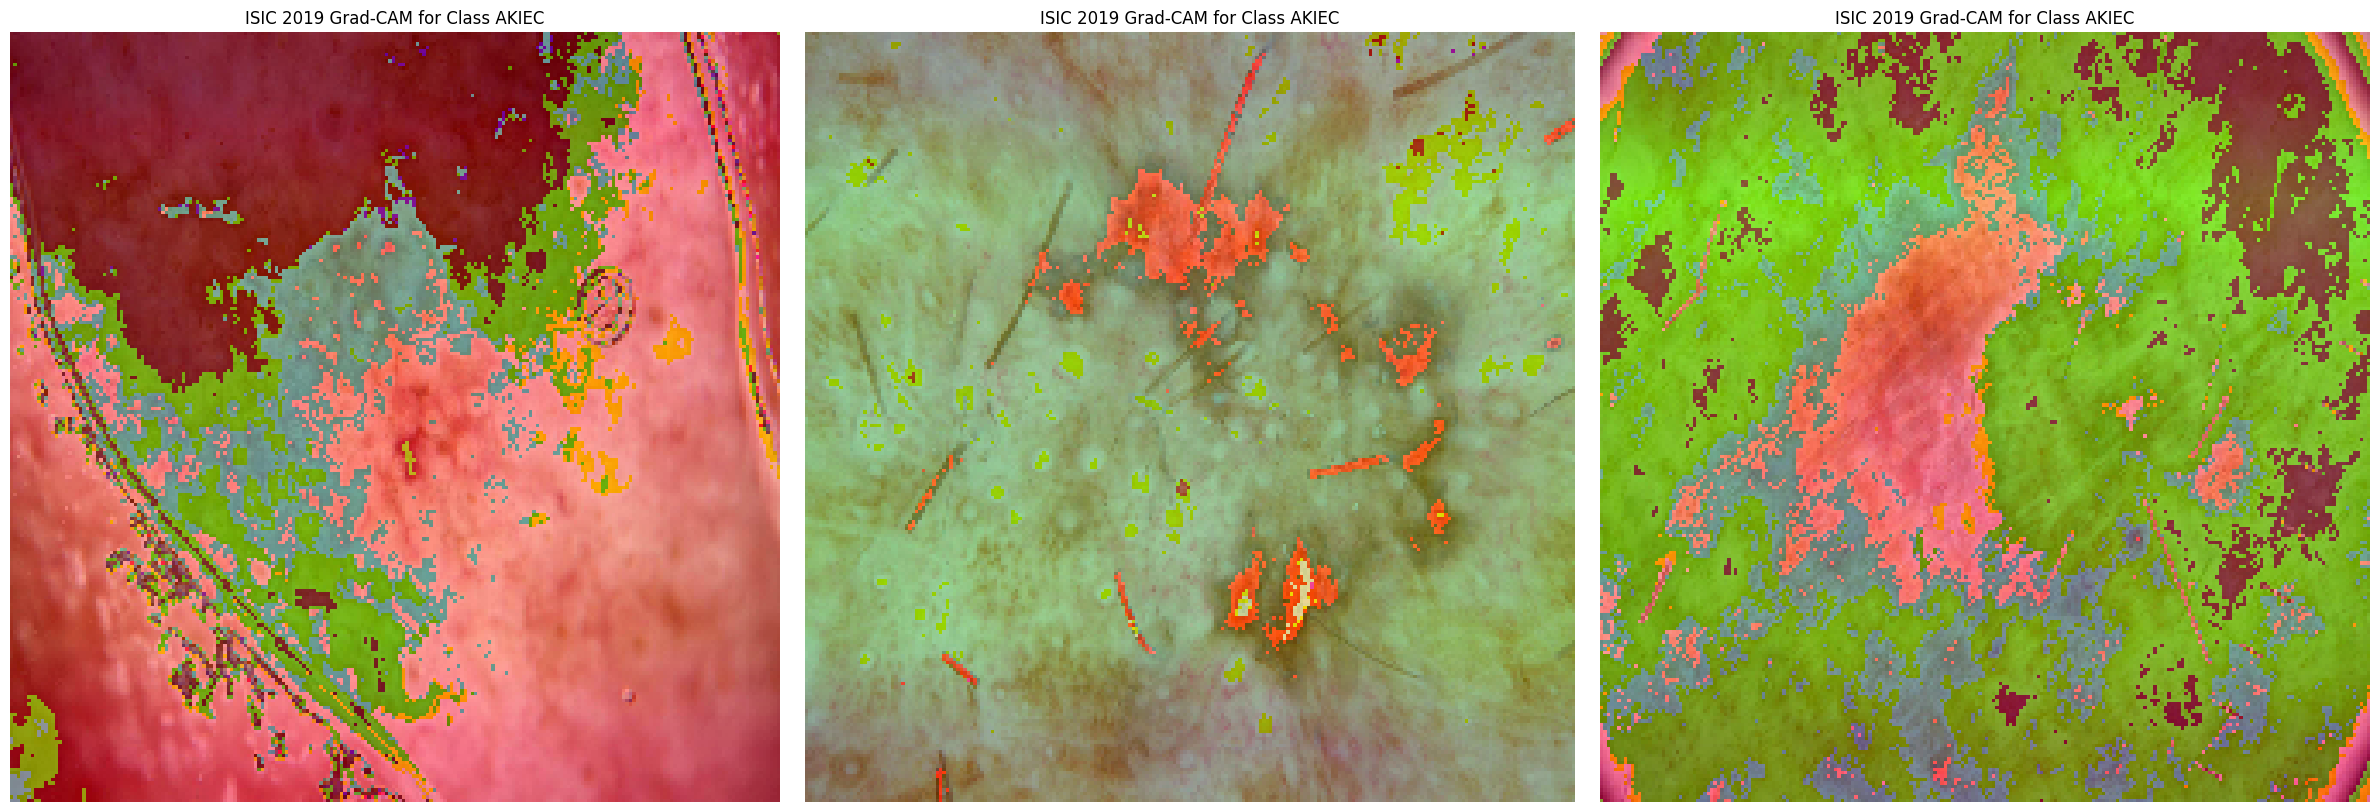

In [220]:
# Visualize Grad-CAM
n_images = min(3, images.shape[0])
fig, axes = plt.subplots(1, n_images, figsize=(8 * n_images, 8))
for i in range(n_images):
    img = images[i]
    superimposed_img = overlay_heatmap(heatmap[i], img)
    axes[i].imshow(superimposed_img)
    axes[i].set_title(f'ISIC 2019 Grad-CAM for Class {targetnames[np.argmax(predictions[i])]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()